## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [24]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSBBS'
meas='TOBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

# #read data
# filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

# read all data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
12152
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|     4|[80 CD 30 D5 80 C...|1990.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|     0|[E0 55 F0 56 00 0...|1991.0|SSSBSBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



In [26]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation FROM weather"
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation FROM weather
+-----------+--------+---------+---------+
|    station|latitude|longitude|elevation|
+-----------+--------+---------+---------+
|USS0019L17S| 38.4333|-119.3667|   2804.2|
|USS0019L17S| 38.4333|-119.3667|   2804.2|
|USS0019L17S| 38.4333|-119.3667|   2804.2|
|USS0019L17S| 38.4333|-119.3667|   2804.2|
+-----------+--------+---------+---------+
only showing top 4 rows



In [27]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station)
19,US1CAAM0002,38.4969,-120.5604,1063.1,2
51,US1CAAM0003,38.4986,-120.5364,1115.3,1


In [25]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather


AnalysisException: u"cannot resolve '`coeff_1`' given input columns: [measurement, undefs, elevation, latitude, year, vector, longitude, label, station]; line 1 pos 45;\n'Project [station#312, latitude#309, longitude#310, elevation#308, 'coeff_1]\n+- SubqueryAlias weather, `weather`\n   +- Relation[elevation#308,latitude#309,longitude#310,measurement#311,station#312,undefs#313L,vector#314,year#315,label#316] parquet\n"

In [19]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
45,USC00040943,38.2119,-119.0142,2551.2,45,-477.269342
27,USC00041072,38.2575,-119.2286,1972.1,45,-0.395695


In [28]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

KeyError: 'avg(coeff_1)'

## Map

In [29]:
min_lat = pdf['latitude'].min() - 0.1
max_lat = pdf['latitude'].max() + 0.1
min_long = pdf['longitude'].min() - 0.1
max_long = pdf['longitude'].max() + 0.1

In [30]:
print min_lat, max_lat, min_long, max_long

38.1119 39.1833 -121.1167 -115.3128


In [38]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8)
    circles.append(c)
    m.add_layer(c)
m    

In [23]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(800*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

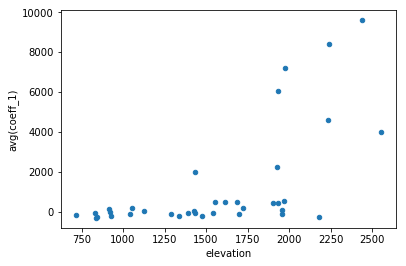

In [12]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');